In [239]:
%matplotlib inline
from glob import glob
import itertools
import math

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [240]:
data = {}
for data_file in itertools.chain(glob("results/*.pkl.gz"), glob("results/predicted/*.pkl.gz")):
    d = pd.read_pickle(data_file)
    for i in range(len(d.dimensions.iloc[0])):
        d[f'dimension_{i}'] = d.dimensions.map(lambda d: int(d[i]))
    data[data_file] = d
    
    # Fix up old measurement format
    if 'predicted' not in data_file:
        d['source'] = 'measured'
        for c in ['L1', 'L2', "L3"]:
            for a in ["_accesses", "_misses", "_evicts"]:
                try:
                    d[c+a+"_float"] = d[c+a].map(float)
                except KeyError:
                    pass
    
df = pd.concat(data.values(), ignore_index=True)

## `likwid-perfctr` Measurement on 1D Kernels

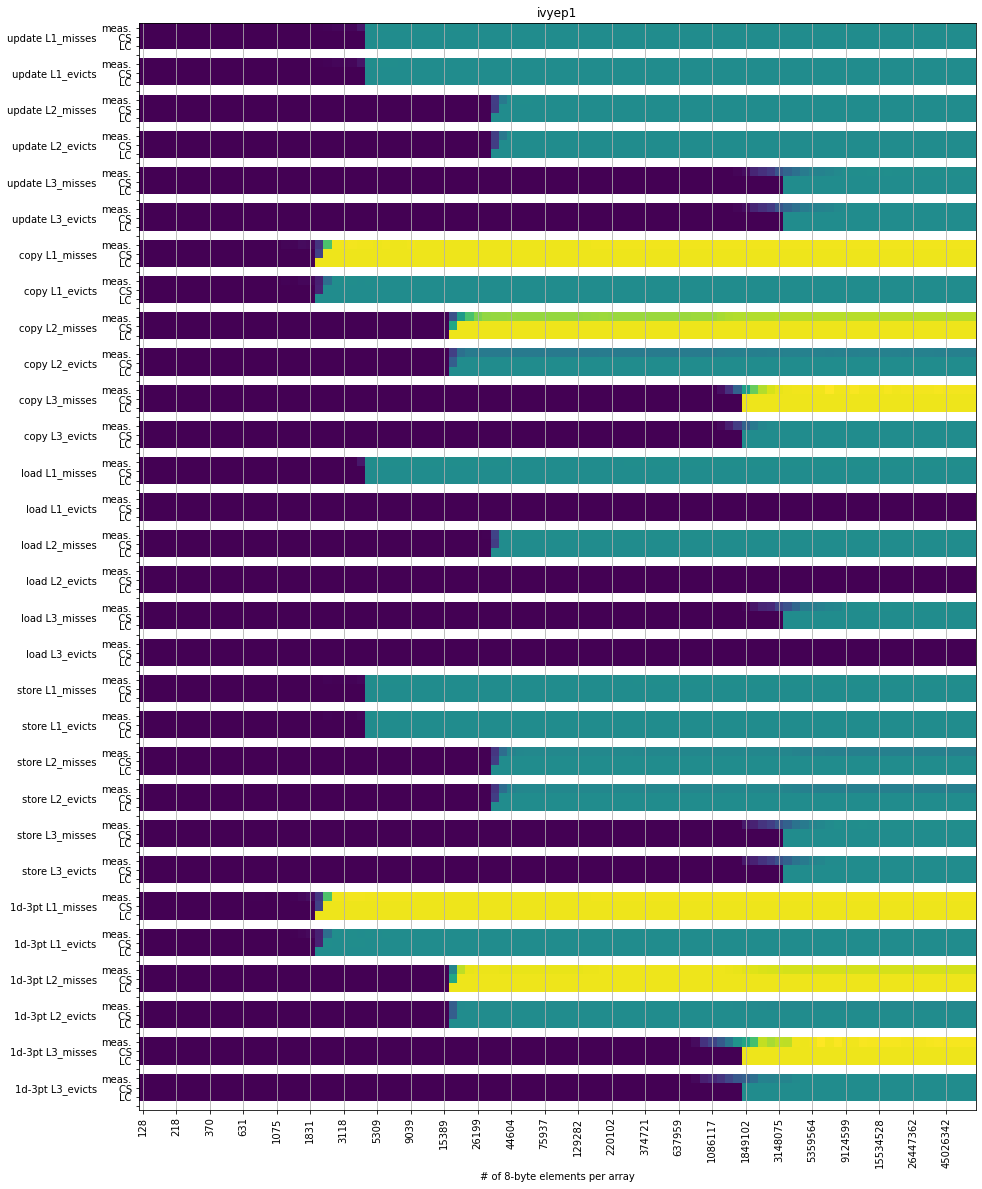

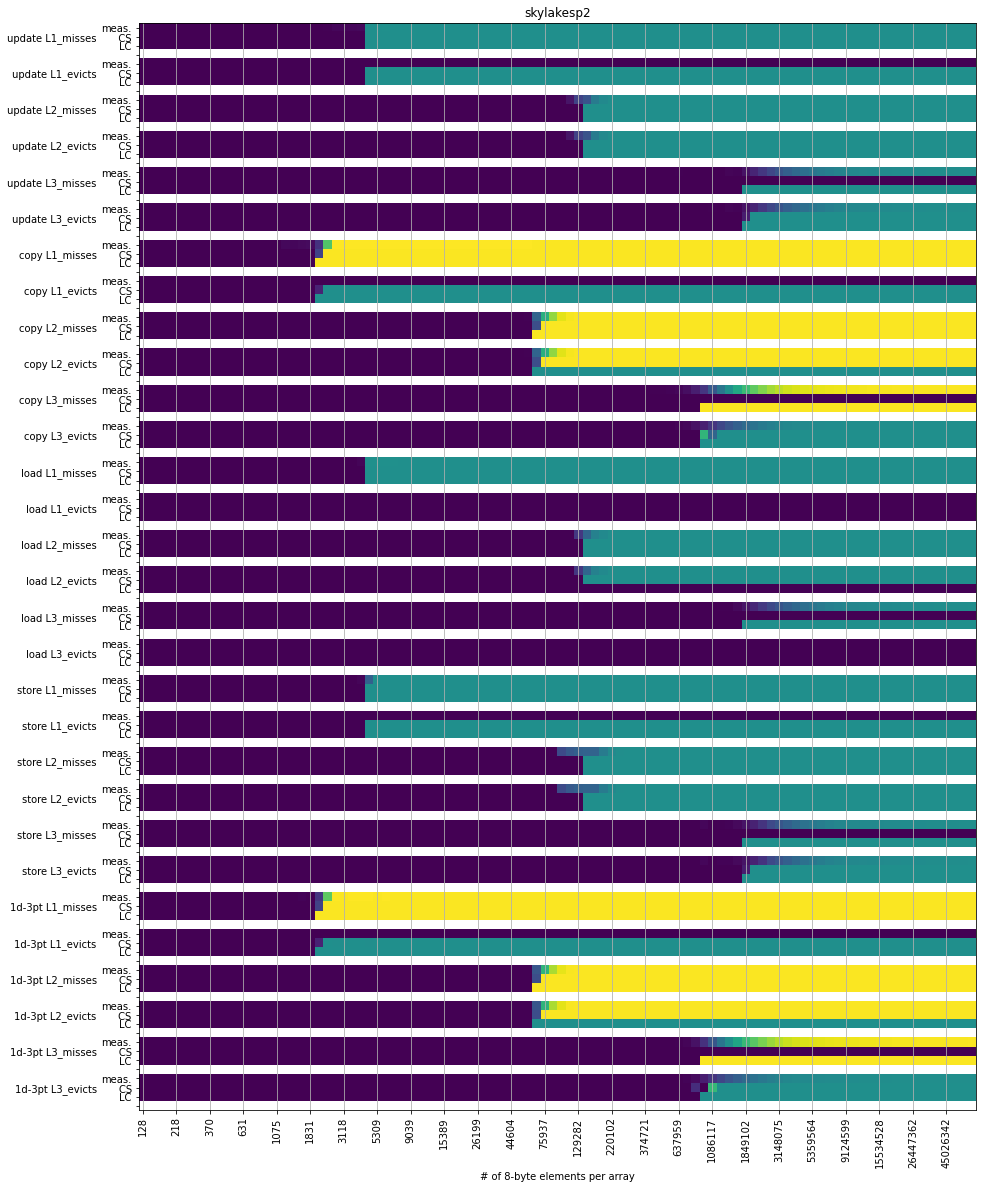

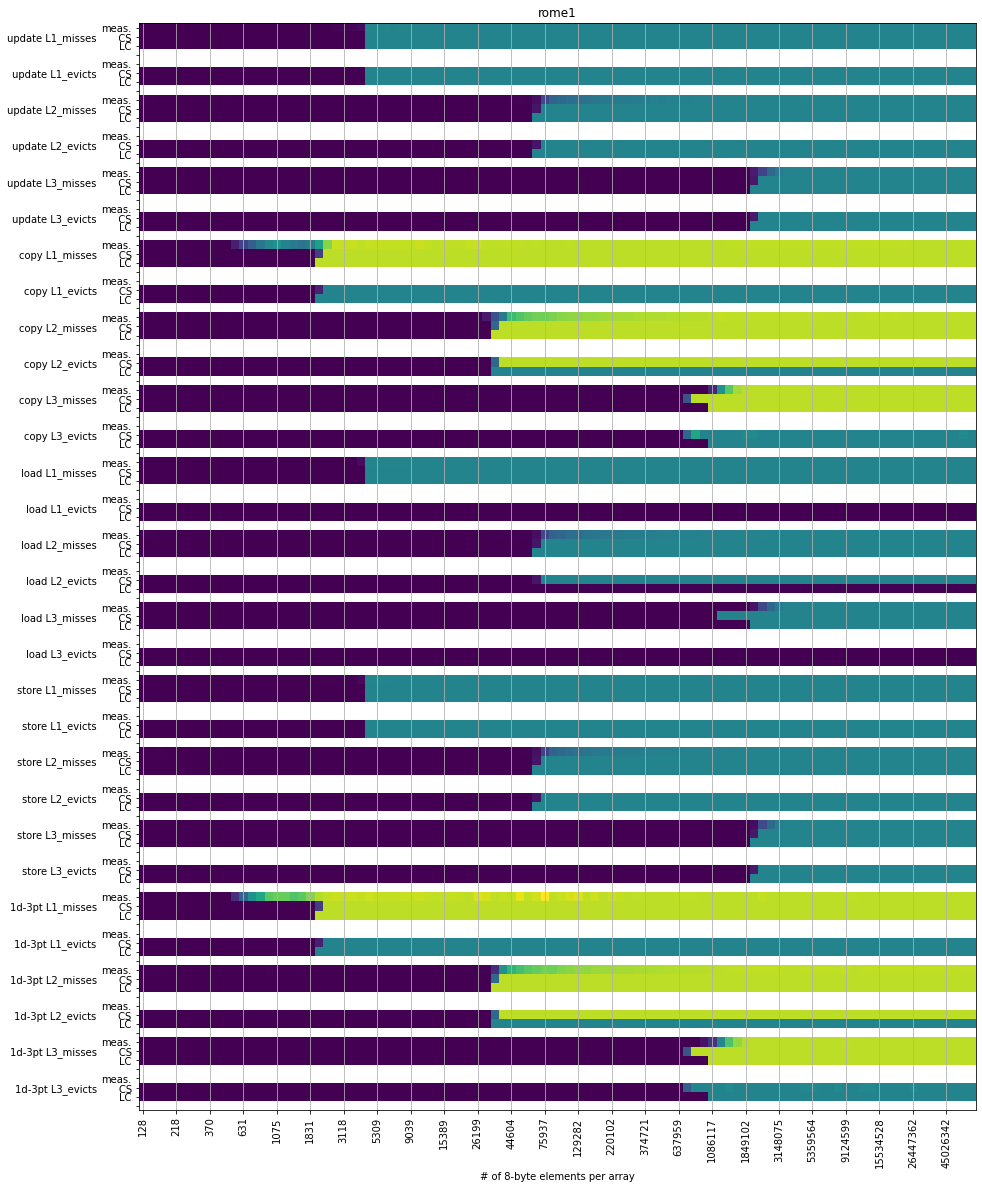

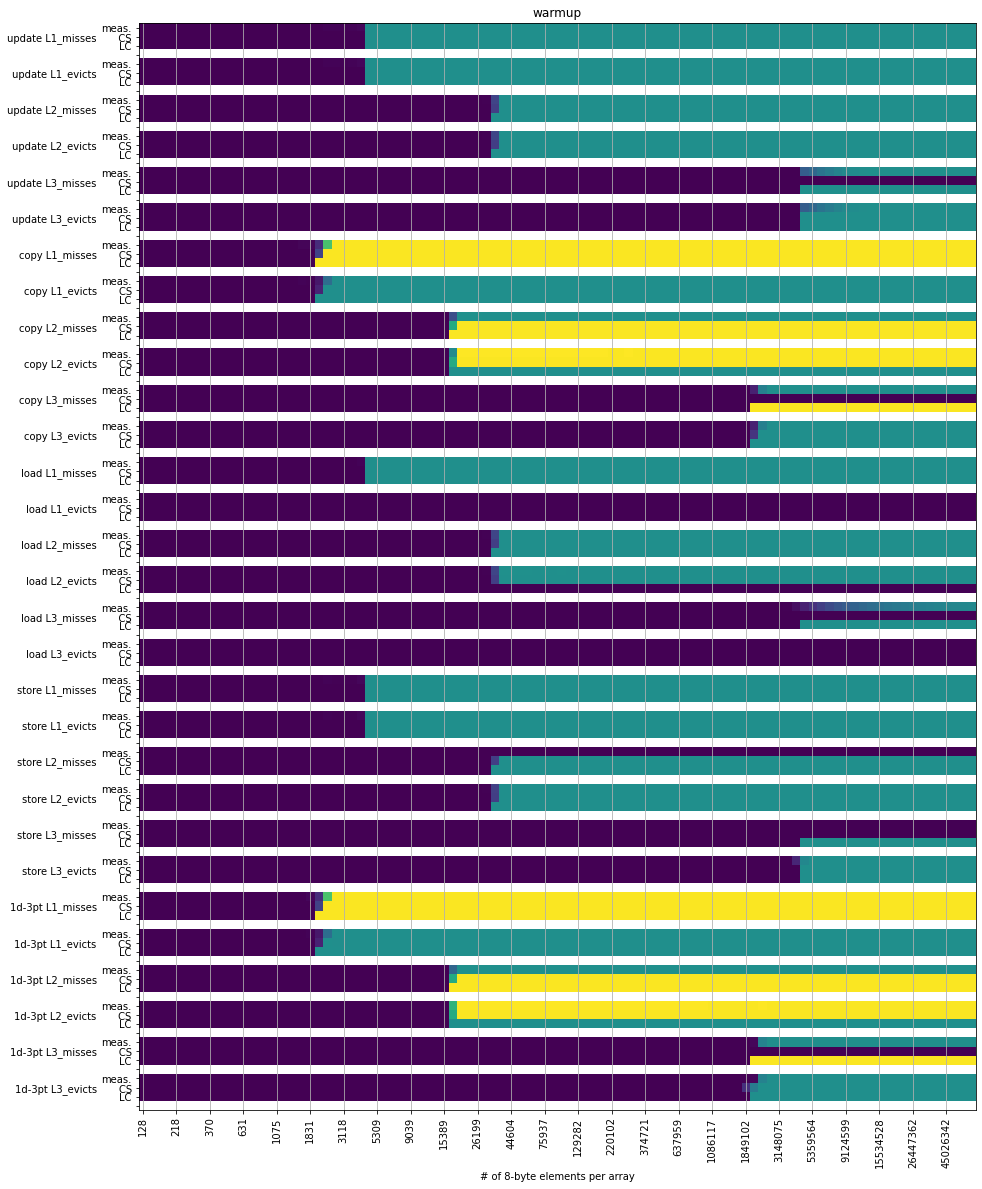

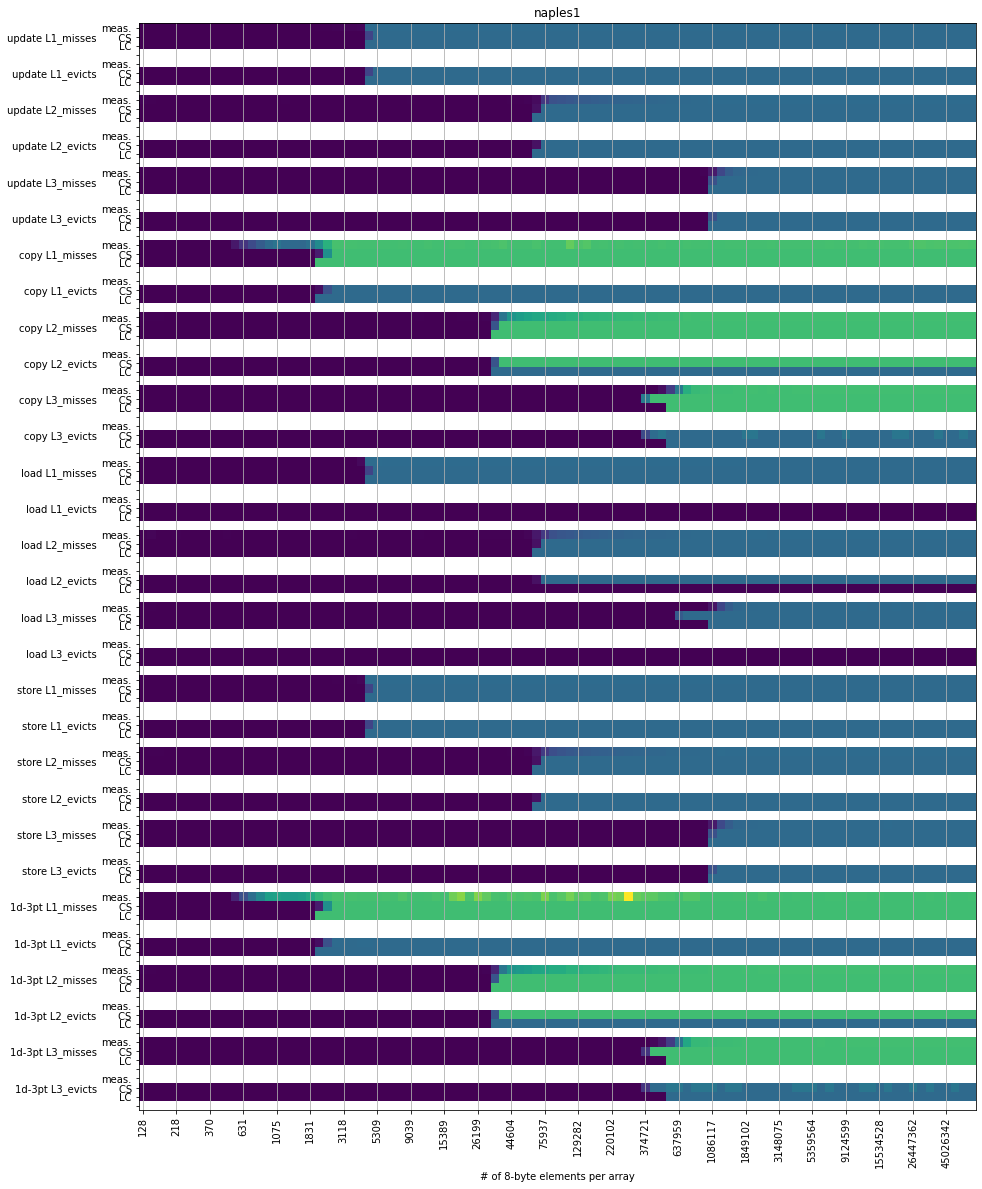

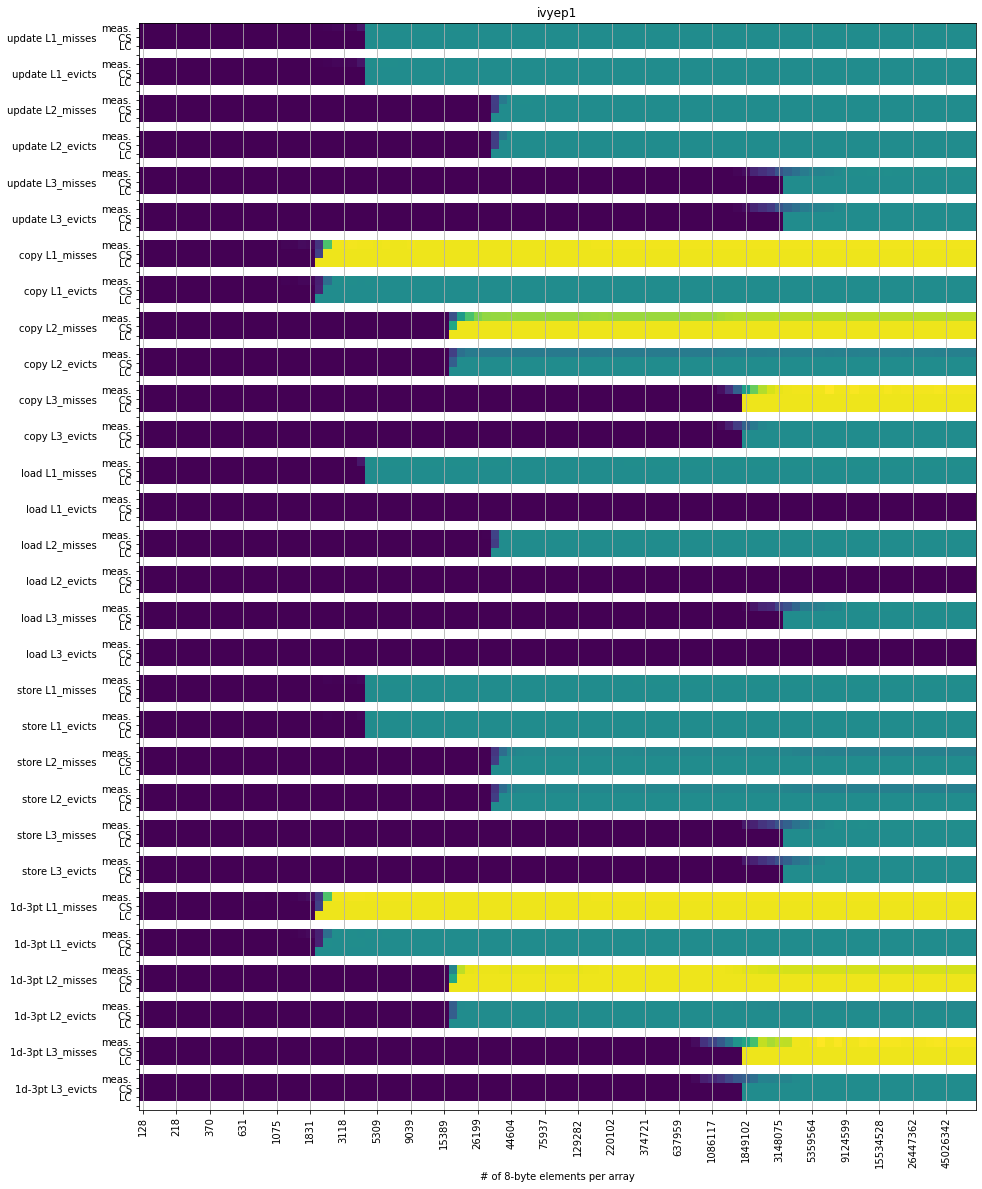

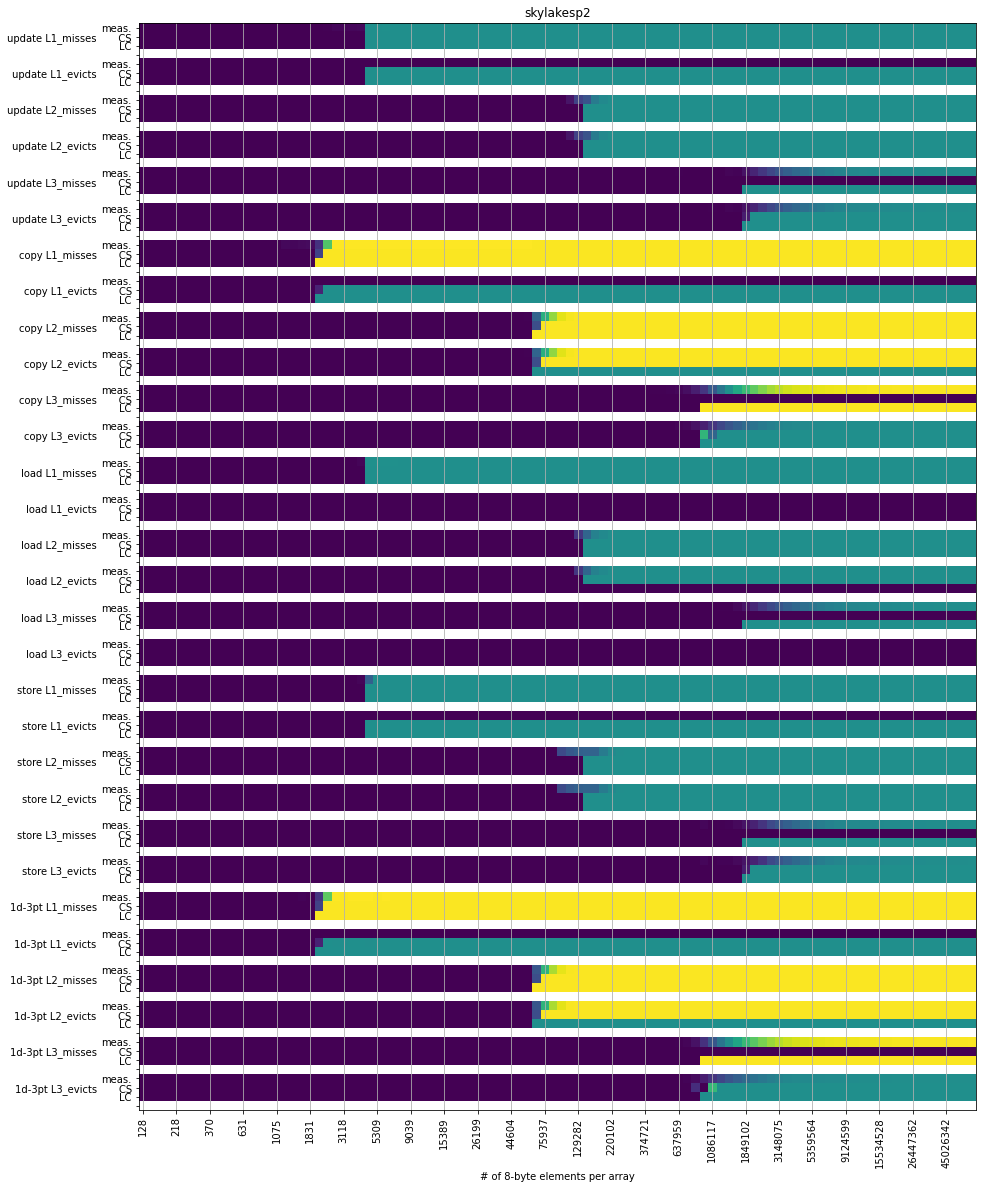

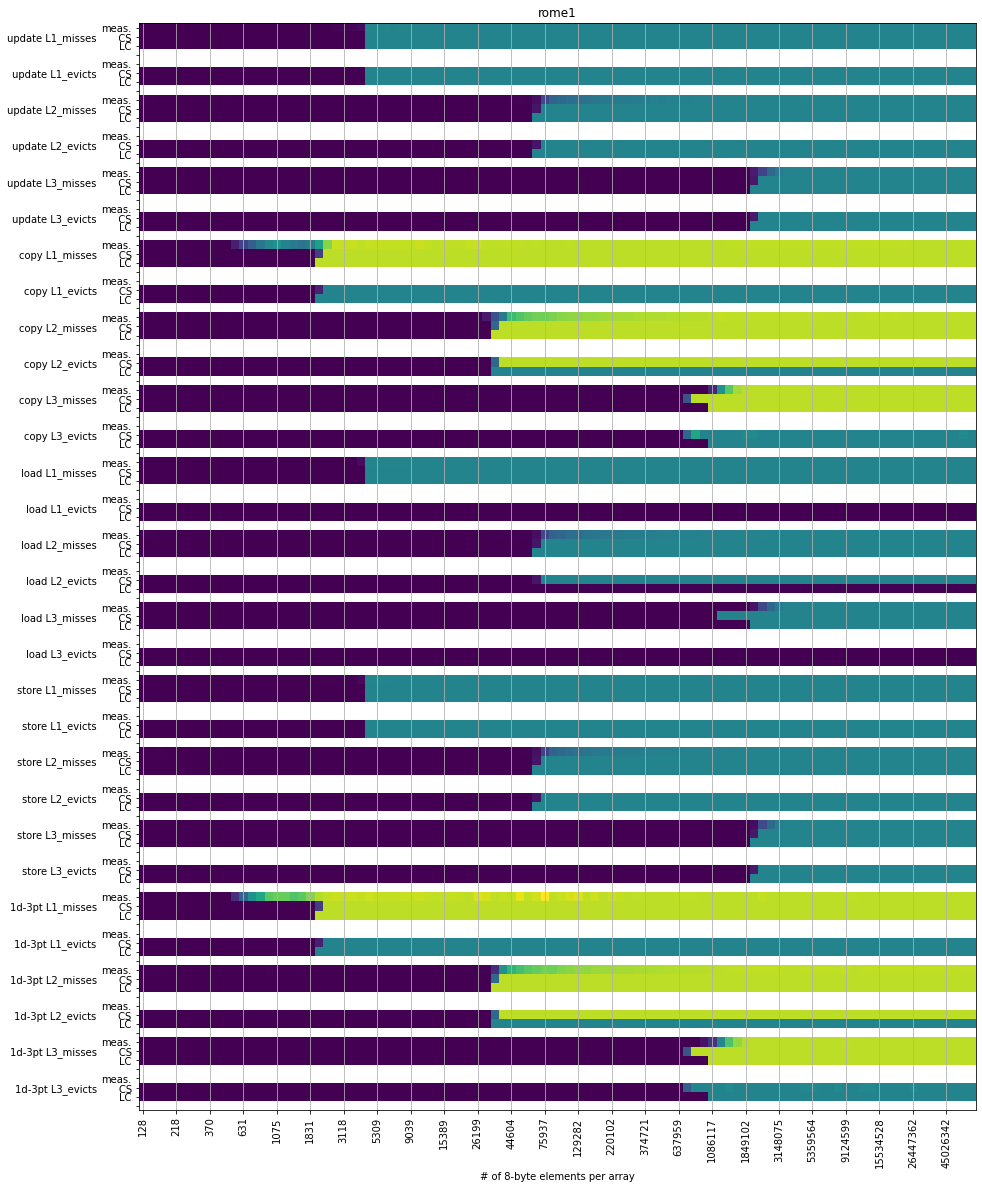

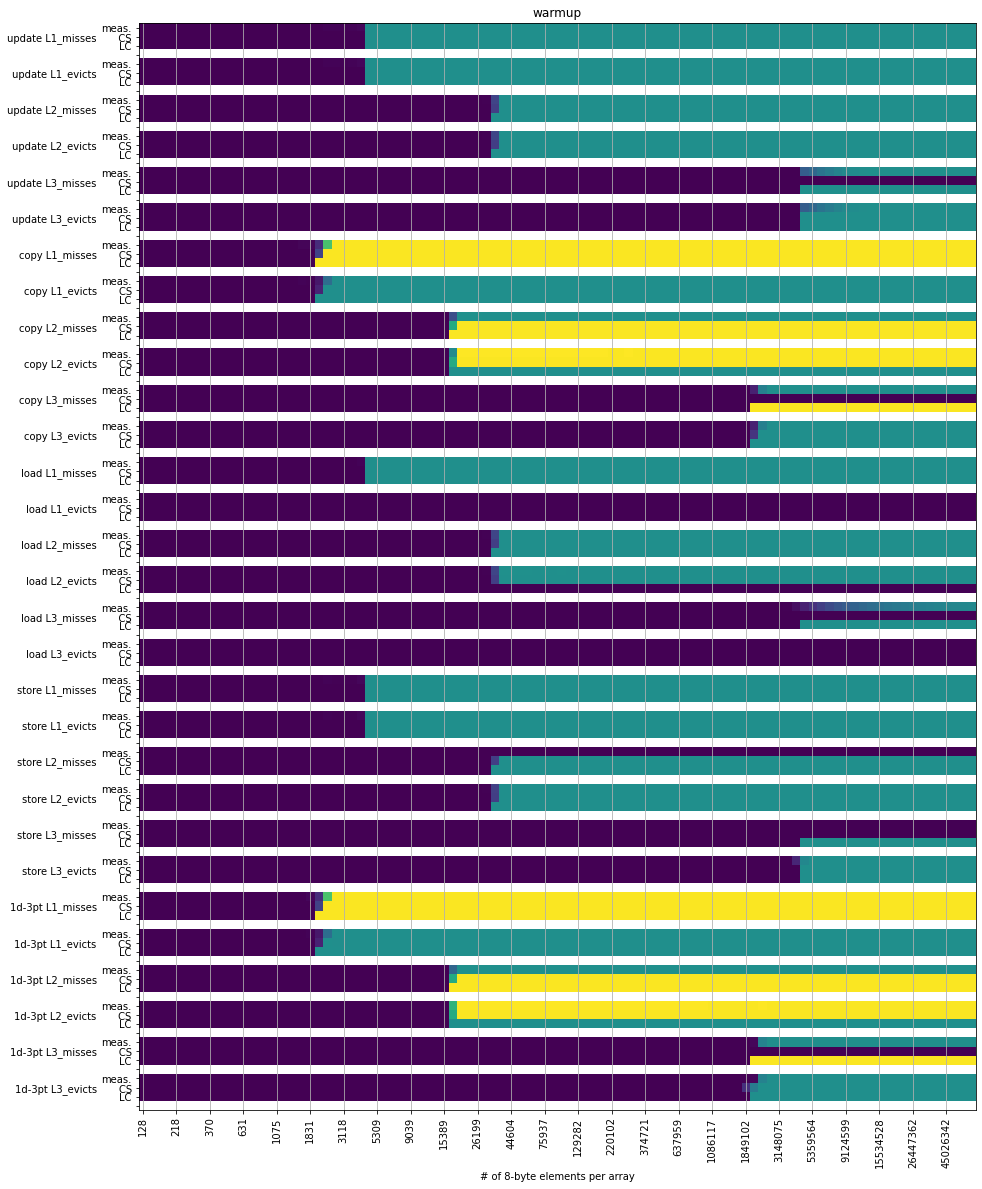

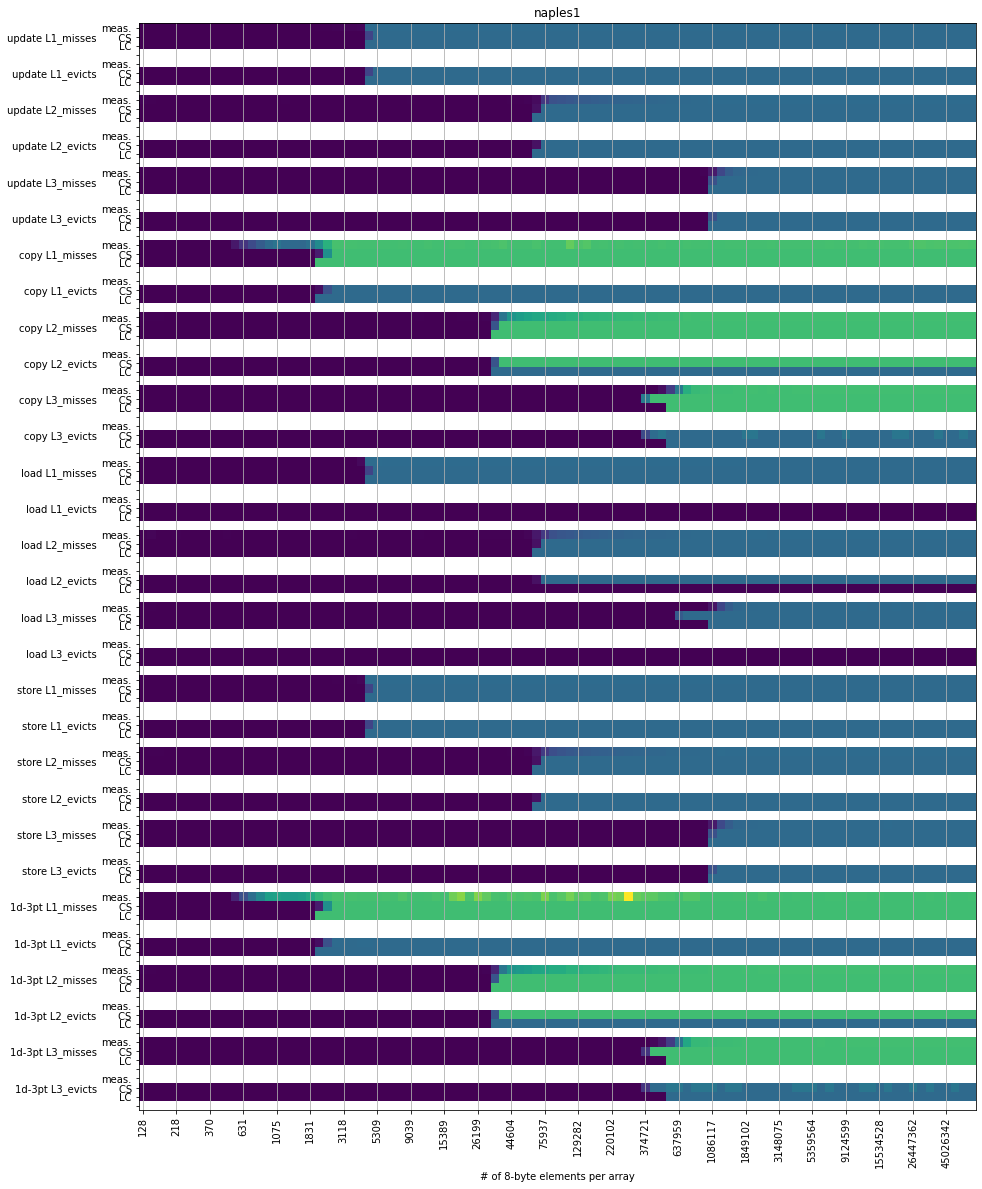

In [241]:
hosts = df.hostname.unique()
kernels = ['update', 'copy', 'load', 'store', '1d-3pt']
columns = [f'{c}_{a}_float' for c, a in itertools.product(
    ['L1', 'L2', "L3"], ["misses", "evicts"])]

for ih, h in enumerate(hosts):
    fig, ax = plt.subplots(figsize=(15,20))
    ax.set_title(h)
    pltdata = []
    yticklabels = []
    for k in kernels:
        d = df.query("kernel == @k and hostname == @h").sort_values(['dimension_0'])
        for c in columns:
            for s in ['measured', 'pycachesim', 'layer-conditions']:
                rowdata = d.query("source == @s")[c].values.transpose()
                if len(rowdata):
                    pltdata.append(rowdata)
                else:
                    pltdata.append([float('nan')]*len(pltdata[-1]))
                if s == 'pycachesim':
                    yticklabels.append(f"{k} {c.rstrip('_float')}       CS")
                else:
                    yticklabels.append({'measured':"meas.", 'pycachesim': 'CS', 'layer-conditions': 'LC'}[s])
            pltdata.append([float('nan')]*len(pltdata[-1]))
            yticklabels.append("")
    
    ax.imshow(pltdata, aspect='auto', interpolation='nearest')
    ax.set_yticks(range(len(pltdata)))
    ax.set_yticklabels(yticklabels)
    ax.set_xticks(range(0, len(d.dimension_0.unique()), 4))
    ax.set_xticklabels(sorted(d.dimension_0.unique())[::4], rotation=90);
    ax.set_xlabel("# of 8-byte elements per array")
    ax.grid(axis='x')
    display(fig)
    #axs[ih,0].colorbar()

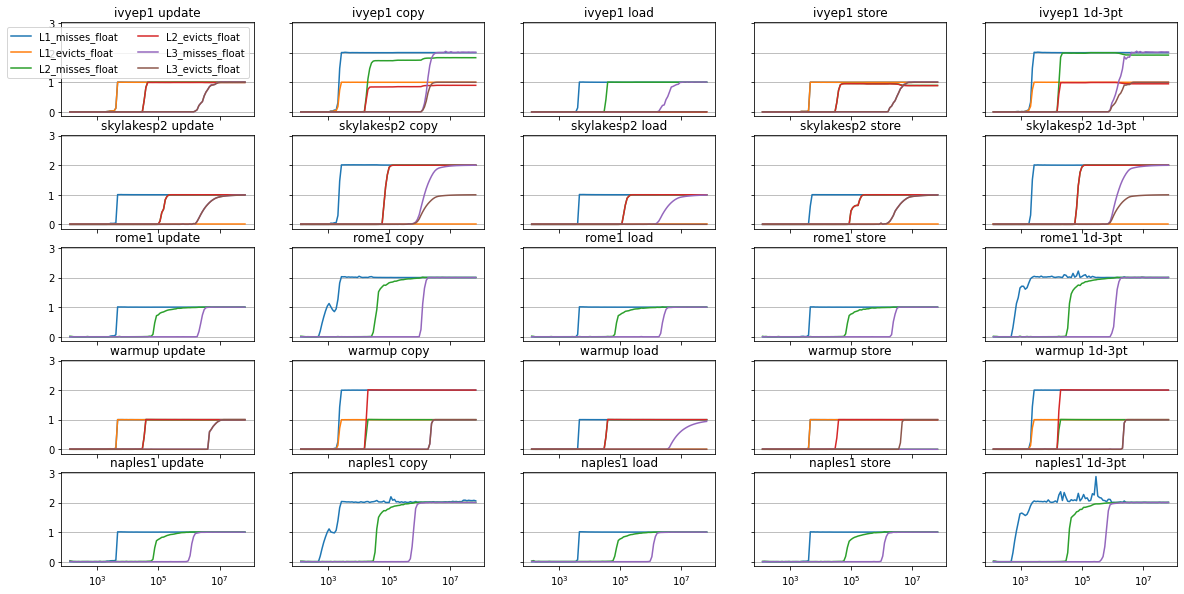

In [242]:
hosts = df.hostname.unique()
kernels = ['update', 'copy', 'load', 'store', '1d-3pt']
vmax = df.query("source == 'measured' and kernel in @kernels")[
    [c for c in df.columns if 'misses_float' in c or 'evicts_float' in c]
].max().values.max()
fig, axs = plt.subplots(len(hosts), len(kernels), squeeze=False, figsize=(20,10), sharex=True, sharey=True)
styles = []
for ih, h in enumerate(hosts):
    for ik, k in enumerate(kernels):
        ax = df.query("source == 'measured' and kernel == @k and hostname == @h").plot(
            y=[f'{c}_{a}_float' for c, a in itertools.product(
                ['L1', 'L2', "L3"], ["misses", "evicts"])],
            x='dimension_0',
            xlabel='',
            logx=True,
            style='-',
            ax=axs[ih, ik],
            legend=False,
            title="{} {}".format(h, k))
        ax.set_yticks(range(0, math.ceil(vmax) + 1))
        #element_counts = [(1*1024, "1Ki"), (2*1024, "2Ki"), (8*1024, "8Ki"), (32*1024, "32Ki"), (64*1024, "64Ki"),
        #                  (4*1024**2, "4Mi"), (8*1024**2, "8Mi"), (16*1024**2, "16Mi")]
        #ax.set_xticks([t for t, l in element_counts])
        #ax.set_xticklabels([l for t, l in element_counts], rotation=90)
        ax.grid(axis='y')
axs[0,0].legend(ncol=2)

## `pycachesim` Prediction on 1D Kernels

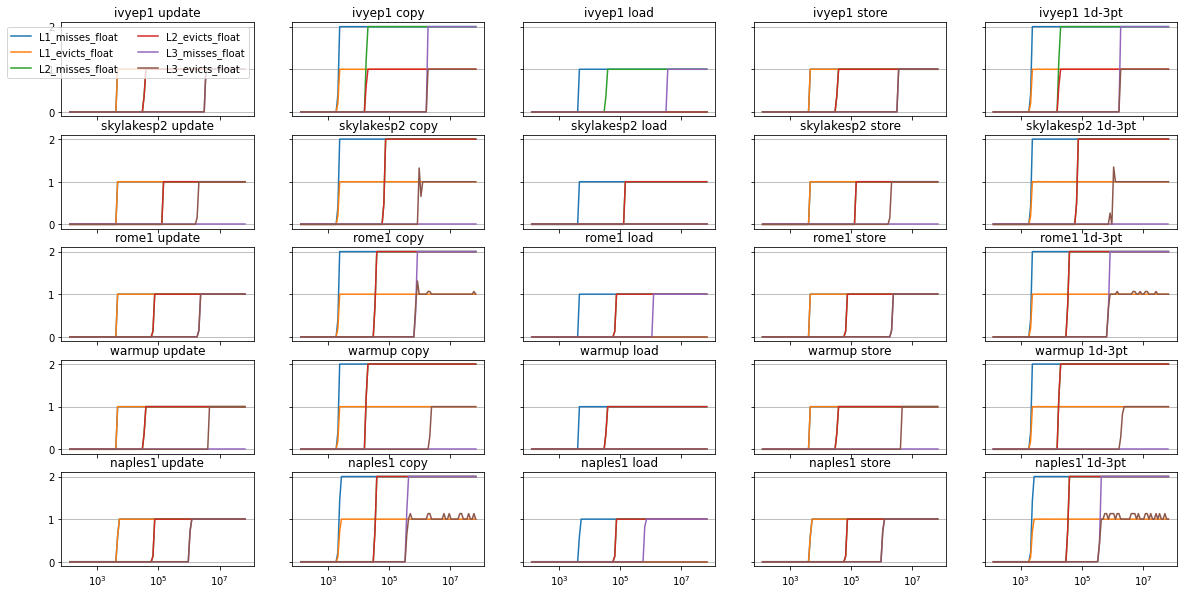

In [243]:
hosts = df.hostname.unique()
kernels = ['update', 'copy', 'load', 'store', '1d-3pt']
fig, axs = plt.subplots(len(hosts), len(kernels), squeeze=False, figsize=(20,10), sharex=True, sharey=True)
for ih, h in enumerate(hosts):
    for ik, k in enumerate(kernels):
        df.query("source == 'pycachesim' and kernel == @k and hostname == @h").plot(
            y=['{}_{}_float'.format(c, a) for c, a in itertools.product(
            ['L1', 'L2', "L3"], ["misses", "evicts"])],
            x='dimension_0',
            xlabel='',
            logx=True,
            ax=axs[ih, ik],
            legend=False,
            title="{} {}".format(h, k))
        axs[ih, ik].grid(axis='y')
axs[0,0].legend(ncol=2)

## LC Prediction on 1D Kernels

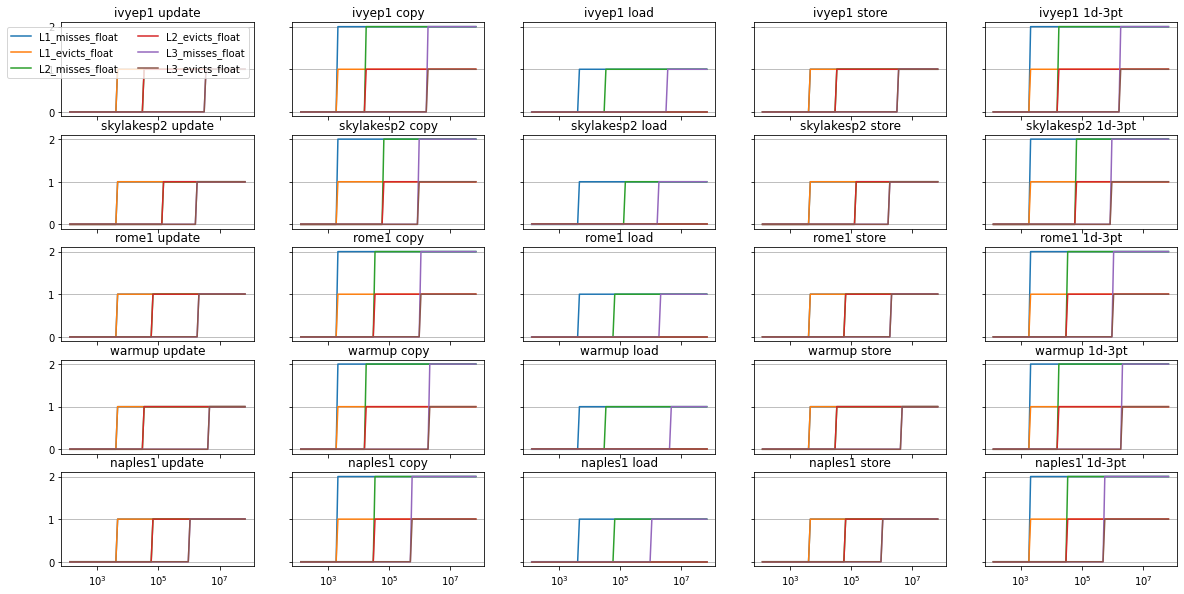

In [244]:
hosts = df.hostname.unique()
kernels = ['update', 'copy', 'load', 'store', '1d-3pt']
fig, axs = plt.subplots(len(hosts), len(kernels), squeeze=False, figsize=(20,10), sharex=True, sharey=True)
for ih, h in enumerate(hosts):
    for ik, k in enumerate(kernels):
        df.query("source == 'layer-conditions' and kernel == @k and hostname == @h").plot(
            y=['{}_{}_float'.format(c, a) for c, a in itertools.product(
            ['L1', 'L2', "L3"], ["misses", "evicts"])],
            x='dimension_0',
            xlabel='',
            logx=True,
            ax=axs[ih, ik],
            legend=False,
            title="{} {}".format(h, k))
        axs[ih, ik].grid(axis='y')
axs[0,0].legend(ncol=2)

In [245]:
def build_const_int_cmap(vmin, vmax, consts=None, const_range=0.1, base_cmap='viridis', segments=512):
    """
    Construct linear colormap with constant color segments.
    
    colors are kept constant around:
     * consts values (const +- const_range)
     * vmin (vmin + const_range)
     * vmax (vmax - const_range)
    """
    if consts is None:
        consts = list(range(math.ceil(vmin), math.floor(vmax)))
    # Color list marks regions which are to keep color constant ('c') or linear/sequential ('l')
    colorlist = ''
    for s in np.linspace(vmin, vmax, segments) - (vmax-vmin)/segments/2:
        if vmin+const_range > s or s > vmax-const_range:
            colorlist += 'c'
        elif any([c-const_range < s < c+const_range for c in consts]):
            colorlist += 'c'
        else:
            colorlist += 'l'
    
    linear_colorlist = mpl.cm.get_cmap(base_cmap, segments)(
        np.linspace(0, 1, segments))
    final_colorlist = []
    j = 0
    cur_seg = ''
    cur_color = None
    for i, s in enumerate(colorlist):
        if s == 'c' and cur_seg != 'c':
            # find center location of const range
            const_length = 0
            for c in colorlist:
                if c == 'c':
                    const_length += 1
                else:
                    break
            cur_color = linear_colorlist[i + const_length // 2]
        elif s == 'c':
            final_colorlist.append(cur_color)
        else:
            final_colorlist.append(linear_colorlist[i])
        cur_seg = s
    return mpl.colors.ListedColormap(final_colorlist)

In [259]:
def plot2d(kernel, source, xcol='dimension_2', ycol='dimension_1', vmin=None, vmax=None, base_cmap='rainbow'):
    pltdata = df.query("kernel == @kernel and source == @source").sort_values(xcol)
    hosts = sorted(df.hostname.unique())
    caches = ['L1', 'L2', 'L3']
    values = pltdata[[c+"_misses_float" for c in caches]].values
    vmin_data = math.floor(values.min())
    if vmin is None:
        vmin = vmin_data
    vmax_data = math.floor(values.max())
    if vmax is None:
        vmax = vmax_data
    cmap = build_const_int_cmap(vmin, vmax, base_cmap=base_cmap)
    ys = sorted(pltdata[ycol].unique())
    xs = sorted(pltdata[xcol].unique())
    fig, axs = plt.subplots(len(caches), len(hosts), figsize=(20,10), squeeze=False, sharex=True, sharey=True)
    fig.suptitle(f"{kernel} {source}", y=0.95, fontsize=20)
    for i, h in enumerate(hosts):
        for j, c in enumerate(caches):
            if j == 0:
                axs[j,i].set_title(h)
            if i == 0:
                axs[j,i].set_ylabel(c+" misses")
            imdata = np.empty((len(ys), len(xs)))
            imdata.fill(float('nan'))
            d = pltdata.query("hostname == @h")
            for yi, y in enumerate(ys):
                row = d.query(ycol+' == @y')[c+'_misses_float'].values.transpose()
                imdata[yi,:len(row)] = row
            im = axs[j,i].imshow(imdata, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower', interpolation='nearest')
            axs[j,i].set_yticks(range(0, len(ys), 4))
            axs[j,i].set_yticklabels([int(y) for y in ys][::4])
            axs[j,i].set_xticks(range(0, len(xs), 4))
            axs[j,i].set_xticklabels([int(x) for x in xs][::4], rotation=90)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=range(math.floor(vmin), math.floor(vmax)+1))
    ytl = [str(t) for t in range(math.floor(vmin), math.floor(vmax)+1)]
    if vmax < vmax_data:
        ytl[-1] = '≥' + ytl[-1]
    if vmin > vmin_data:
        ytl[0] = '≤' + ytl[0]
    cbar.ax.set_yticklabels(ytl)
    return fig, axs

In [274]:
def plot2derr(axsa, axsb):
    hosts = sorted(df.hostname.unique())
    caches = ['L1', 'L2', 'L3']
    fig, axs = plt.subplots(len(caches), len(hosts), figsize=(20,10), squeeze=False, sharex=True, sharey=True)
    for i, h in enumerate(hosts):
        axsa[0,i].set_title(h)
        for j, c in enumerate(caches):
            datap = axsa[j,i].get_images()[0].get_array().data
            datam = axsb[j,i].get_images()[0].get_array().data
            s = (min(datap.shape[0], datam.shape[0]), min(datap.shape[1], datam.shape[1]))
            err = abs(datap[:s[0],:s[1]]-datam[:s[0],:s[1]])
            err_nanmasked = np.ma.array(err, mask=np.isnan(err))
            im = axs[j,i].imshow(err, cmap="PiYG", vmin=-2, vmax=2, origin='lower')
            avg_err = err_nanmasked.sum() / err_nanmasked.count()
            axs[j,i].annotate(f"avg(abserr)={avg_err:.2}", xy=(1, 1), xycoords='axes fraction',
                             horizontalalignment='right', verticalalignment='top',
                             color='red', backgroundcolor='white')
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

## 2d-5pt Kernel

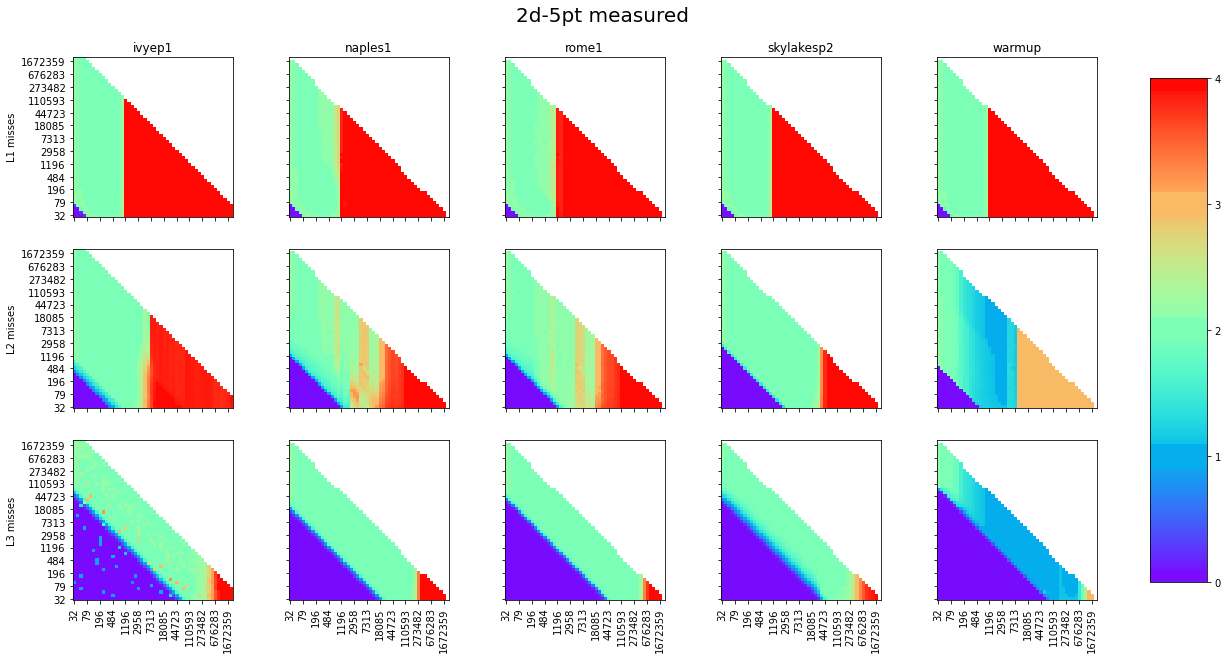

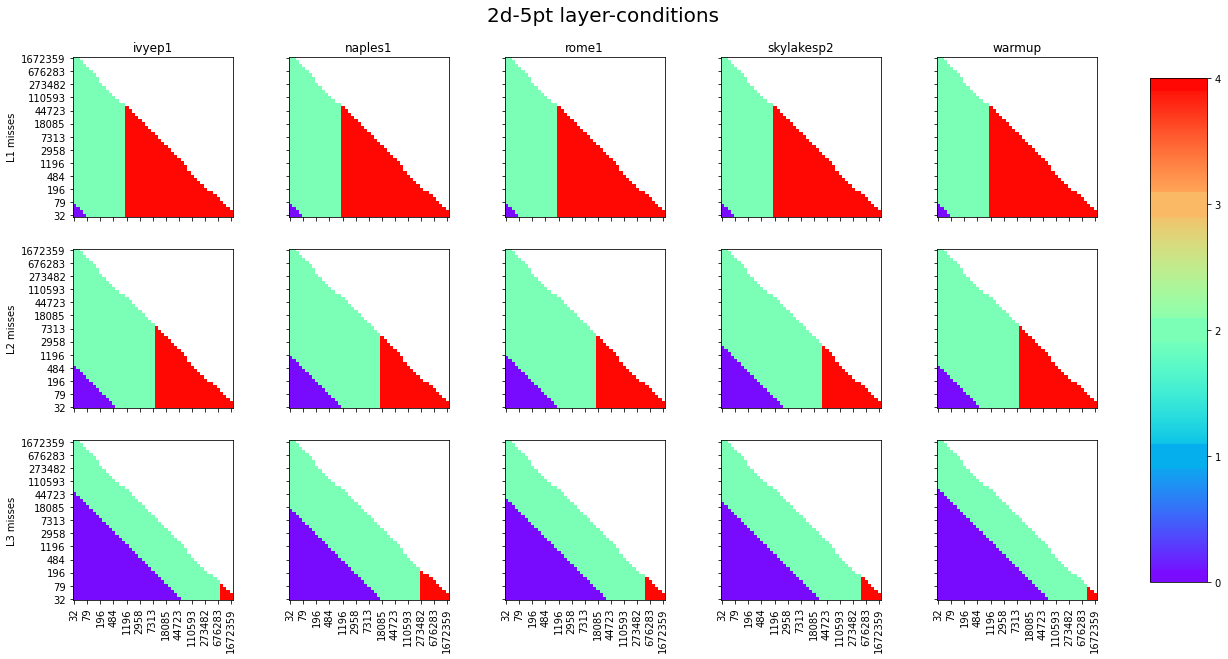

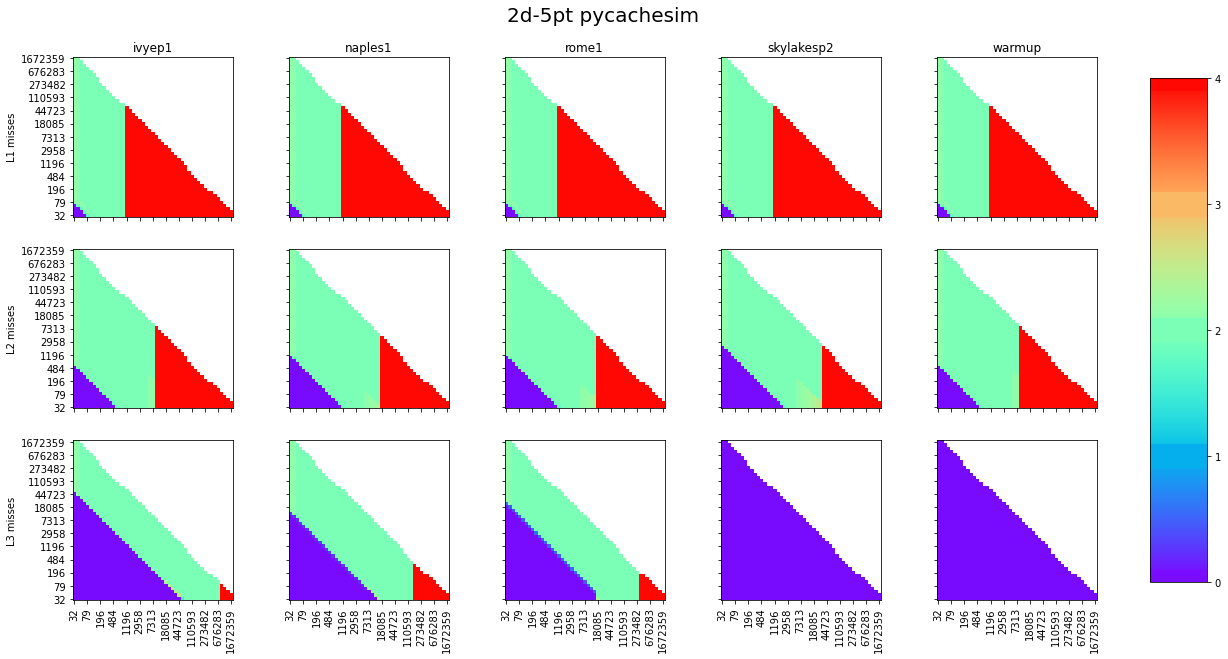

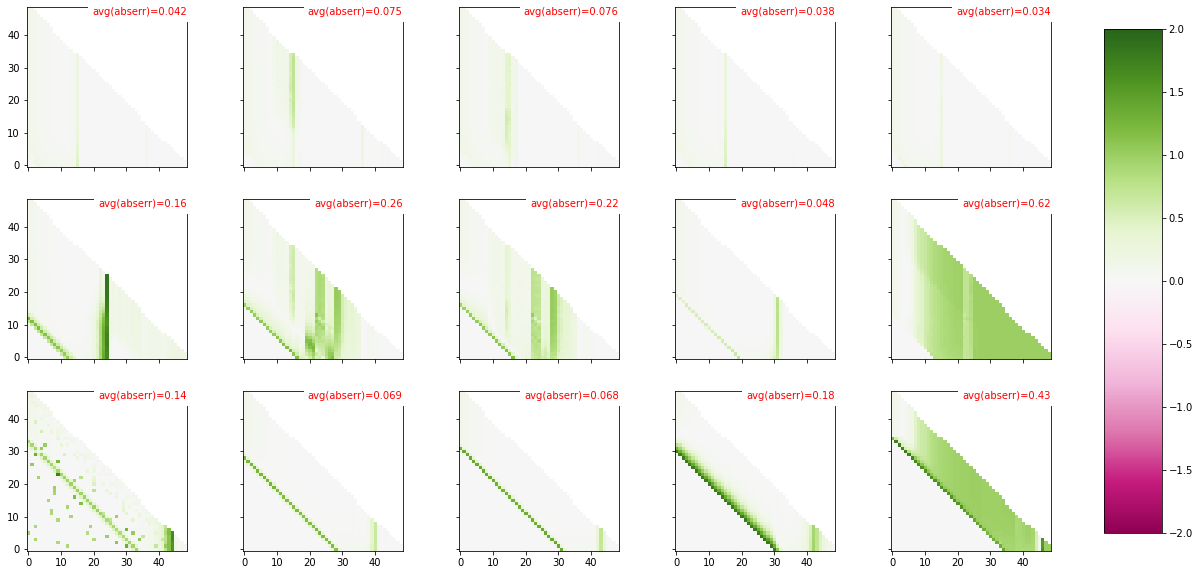

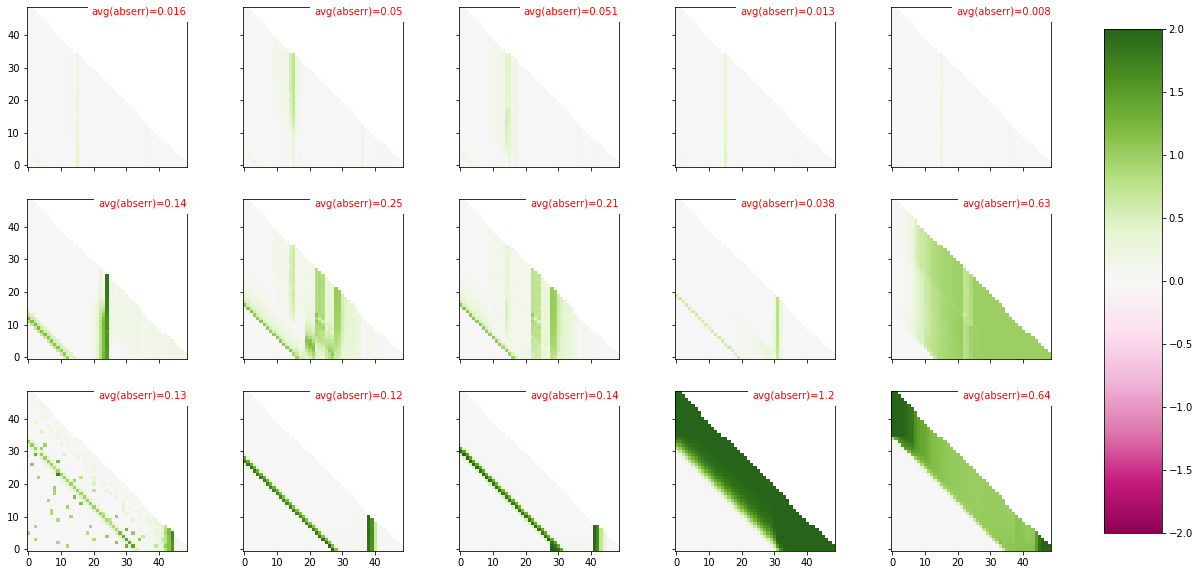

In [275]:
fas = {}
for source in ['measured', 'layer-conditions', 'pycachesim']:
    fas[source] = plot2d('2d-5pt', source, xcol='dimension_1', ycol='dimension_0')
plot2derr(fas['measured'][1], fas['layer-conditions'][1])
plot2derr(fas['measured'][1], fas['pycachesim'][1])

## matvec Kernel

$M*\vec{v} = \vec{r}$ with $M = rows \times cols$

y-axis is cols, x-axis is rows of matrix and length of vectors

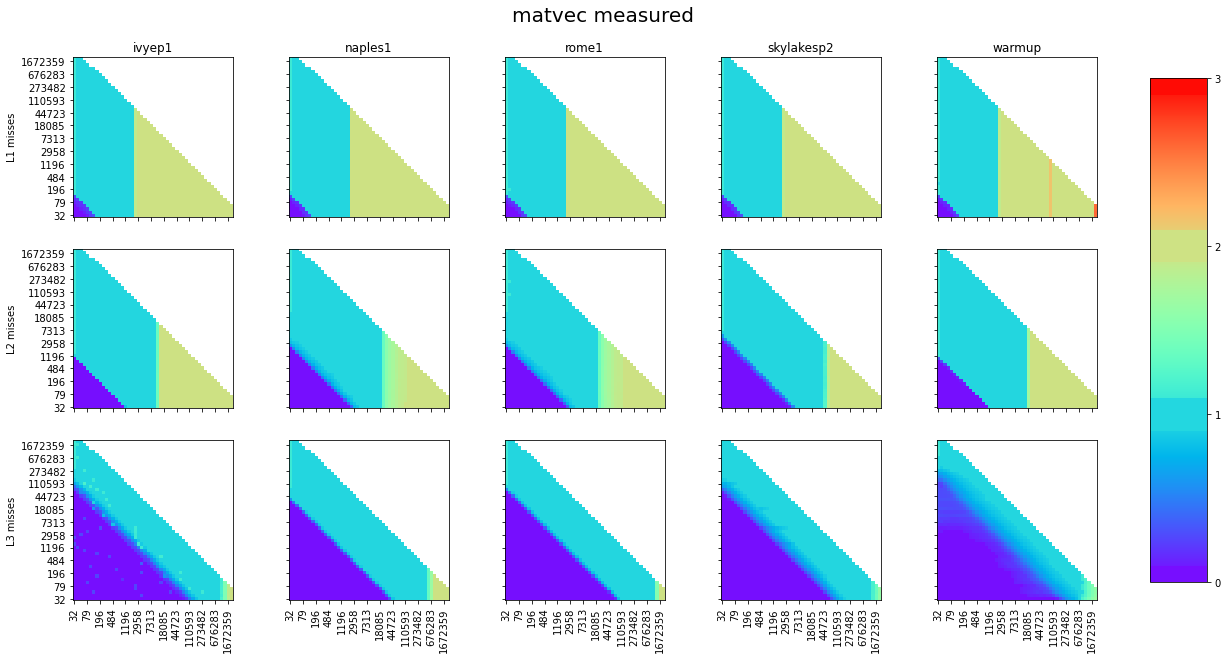

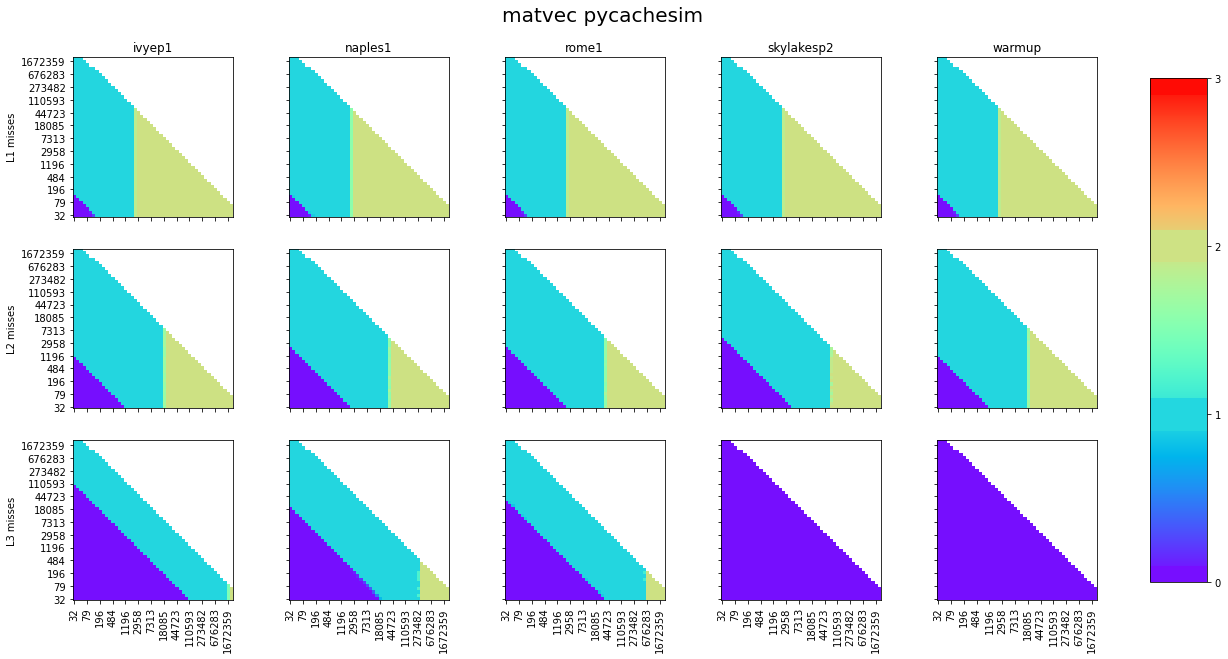

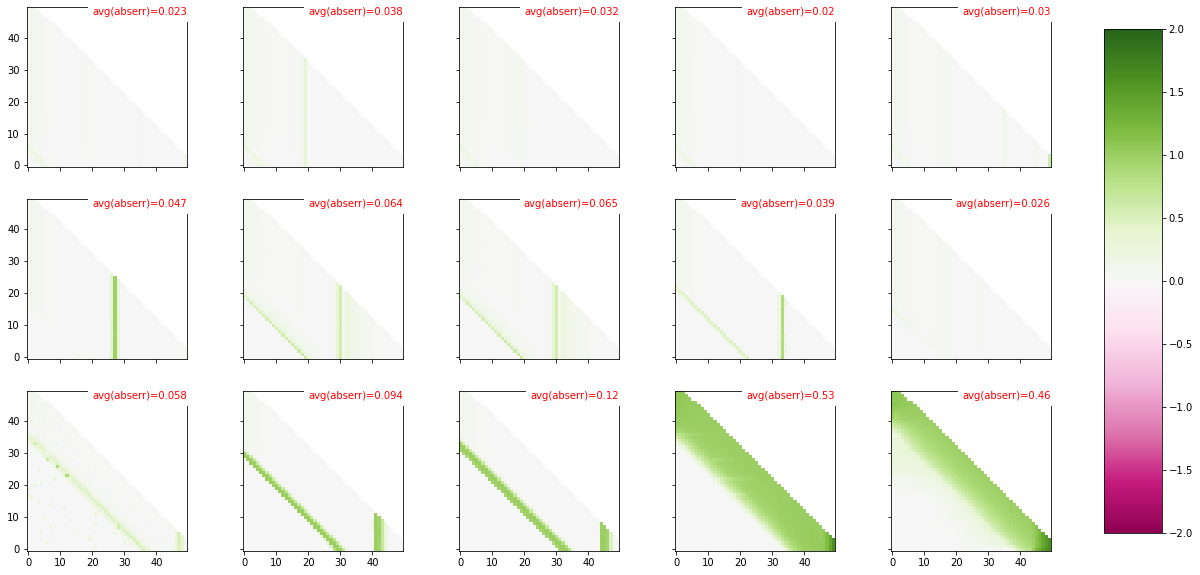

In [276]:
fas = {}
for source in ['measured', 'pycachesim']:
    fas[source] = plot2d('matvec', source, xcol='dimension_1', ycol='dimension_0', vmin=0, vmax=3)

plot2derr(fas['measured'][1], fas['pycachesim'][1])

## `likwid-perfctr` on transmatvec Kernel
$M^T*\vec{v} = \vec{r}$ with $M = rows \times cols$

x-axis is cols, y-axis is rows of original matrix (pre transposed) and length of vectors

ValueError: zero-size array to reduction operation minimum which has no identity

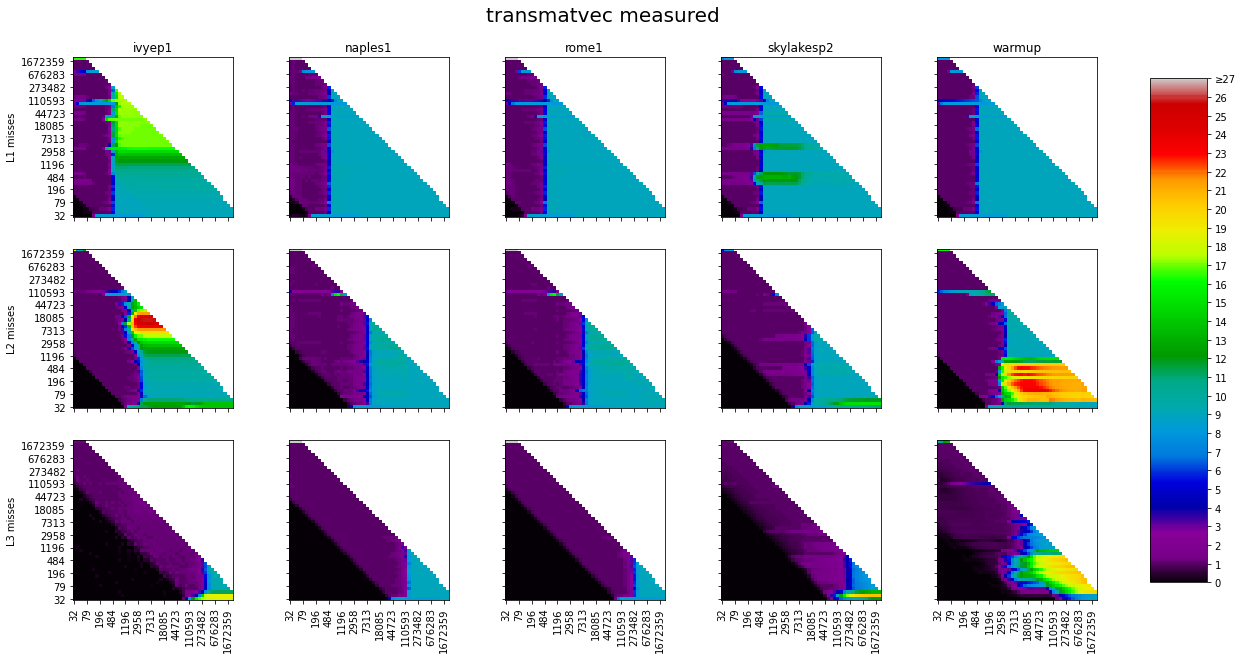

In [261]:
fas = {}
for source in ['measured', 'pycachesim']:
    fas[source] = plot2d('transmatvec', source, xcol='dimension_1', ycol='dimension_0',
                         vmin=0, vmax=27, base_cmap='nipy_spectral')
plot2derr(fas['measured'][1], fas['pycachesim'][1])

## `likwid-perfctr` on 3d-7pt Kernel
$2*\max(\mathrm{cache\_sizes}) \le a*b*c*8\,\mathrm{B} \le 8\,\mathrm{GiB}$

for given inner array dimensions $a$ and $b$, $c$ is selected for the total dataset to not fit in the larges cache.

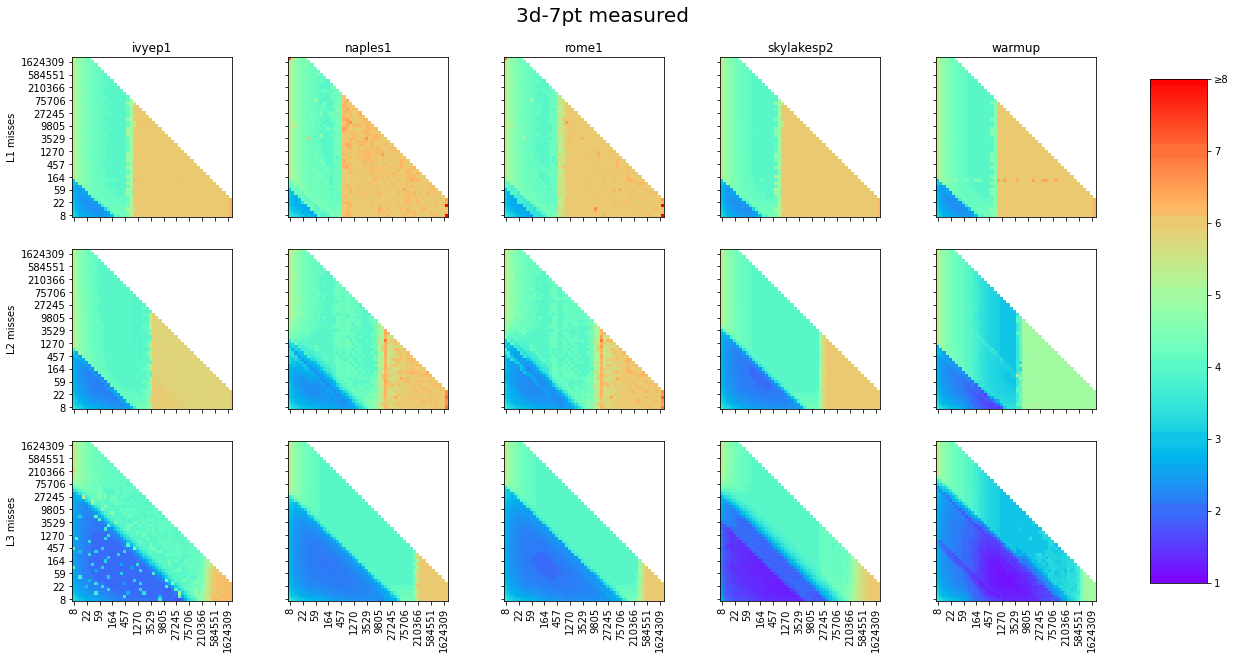

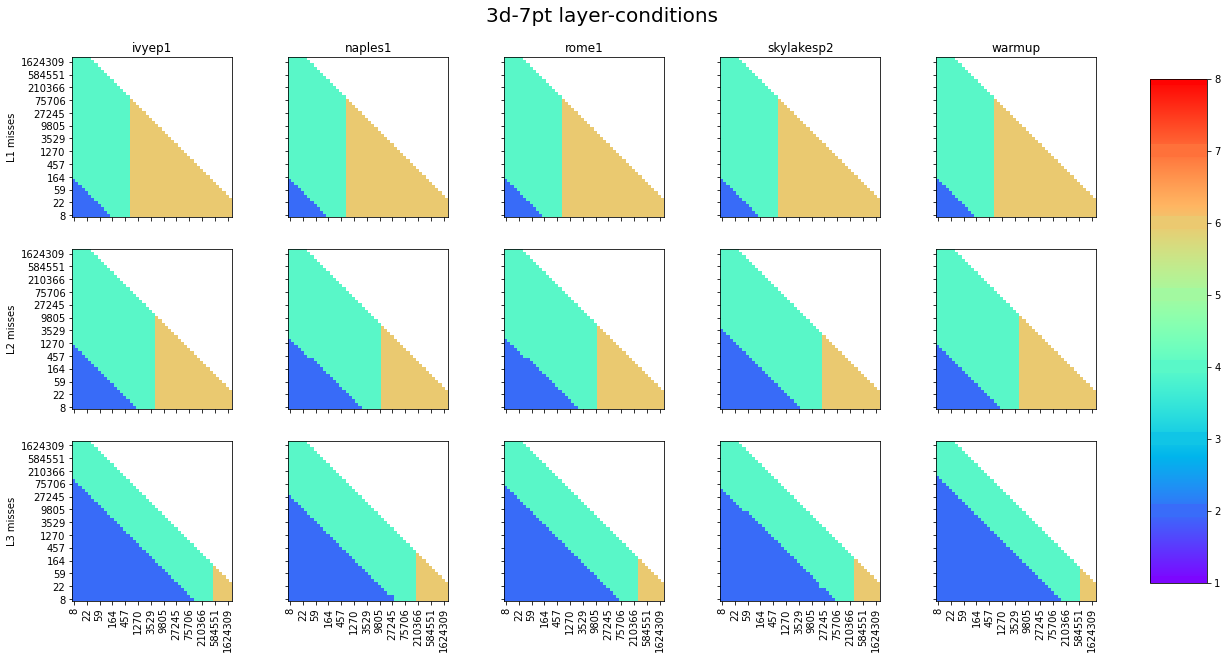

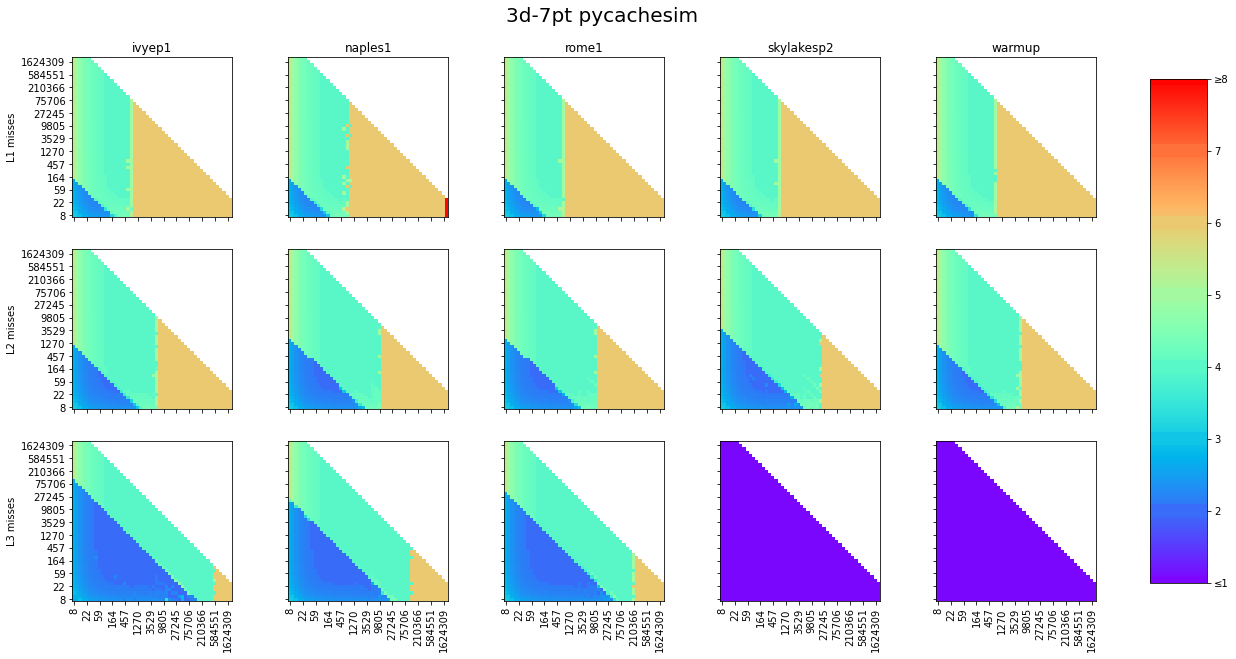

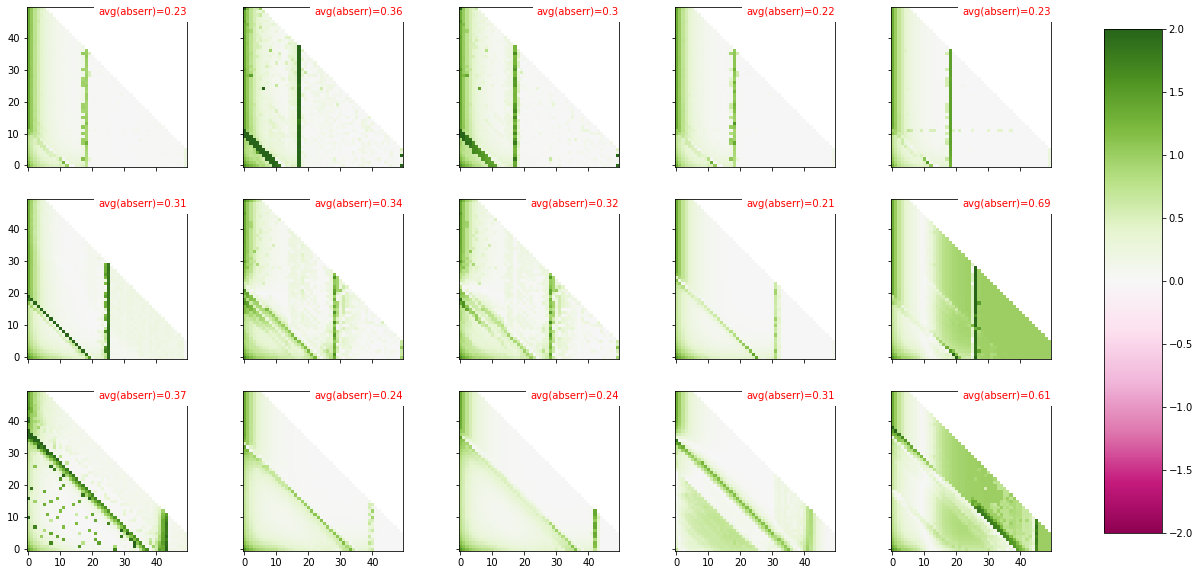

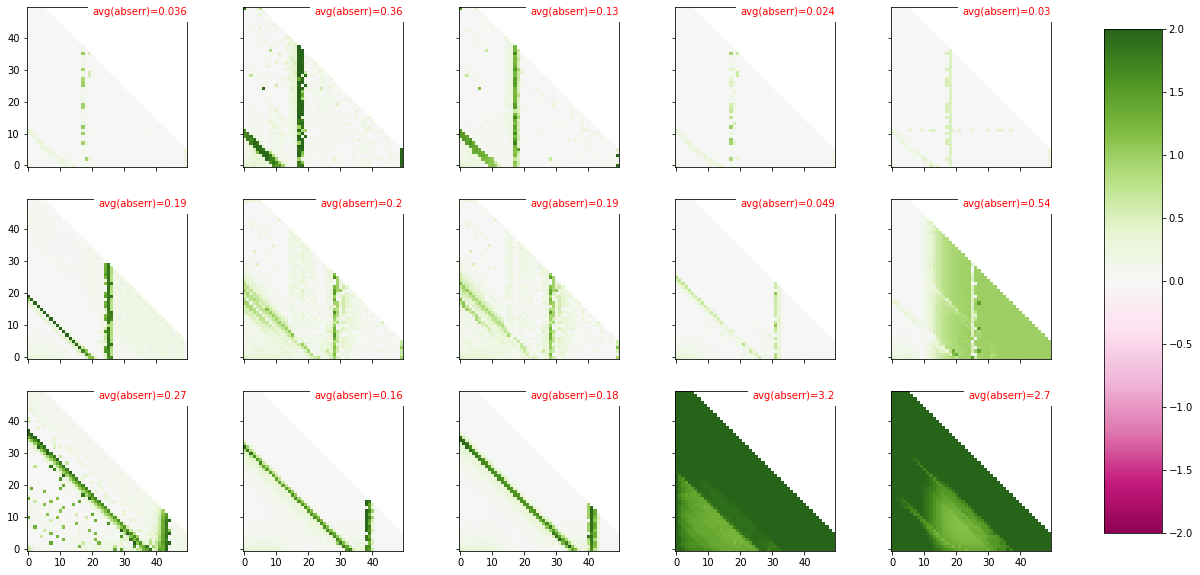

In [277]:
fas = {}
for source in ['measured', 'layer-conditions', 'pycachesim']:
    fas[source] = plot2d('3d-7pt', source, vmin=1, vmax=8)

plot2derr(fas['measured'][1], fas['layer-conditions'][1])
plot2derr(fas['measured'][1], fas['pycachesim'][1])